In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
from typing import Optional
import matplotlib.pyplot as plt
import math

%load_ext autoreload
%autoreload 2
%matplotlib notebook
manualSeed = 999

np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Model environment

### Questions
1. **Data normalization**: Compute across batch ? compute on huge tensor when solving least squares and make it an attribute ? **BATCH**
3. **Smoothness**: In this first implementation, the changes in X0 and X1 are really rough. Should we make them smoother ? For example, make the means follow 2D random walks and the variance vary according to a smooth function ? 
4. **Experiment interpretability**: Is there really a relation between `env.w` and `adam_w` considering that one is for least squares `w.T@x` and the other for logistic regression `sigmoid(w.T@x)`. 
    1. We probably should not use logistic regression but linear regression for comparison sake. However, this is known to be a bad model for classification ...
    2. We may want to do a third experiment in which we use a neural net in higher dimension. In here we could compare sgd loss and different flavours of adam loss. We can also analyze the evolution of the momentum and therefore analyze how adam adapts to non-stationarity.
->> probably not consider least sqaures solution and just monitor the loss of the different optimzers. Gives more freedom regarding the environement.

### Todo
1. **seed**: add a seed to control pytorch random states and be able to replicate experiments !
2. **distribution plot**: add `env.w`, `adam_model.w`, `sgd_model.w` (and then others)
3. **weight error plot**: do it

In [4]:

class Env2(object):
    """Experiment2 environment
    
    Arguments
    ---------
    d: int
        dimensionality of the environment 
        
    lambda_: float
        parameter of the lifetime exponential distribution
        
    batch_size: int
        batch size
        
    N: int
        maximum number of samples to use to solve the least squares problem
        
    p: torch.Tensor
        parameter of the bernoulli label distribution. Must be of size (1)
    
    Attributes
    ----------
    Y: torch.disibutions.distribution.Distribution
        labels distribution
        
    X0: torch.disibutions.distribution.Distribution
        negative samples distribution
        
    X1: torch.disibutions.distribution.Distribution
        positive samples distribution
        
    T: torch.disibutions.distribution.Distribution
        lifetime of X0 and X1 distribution
        
    counter: int
        counts calls to get_batch
        
    tau: int
        lifetime of X0 and X1
    
    mu0, sigma0: torch.Tensor, torch.Tensor
        parameters of Gaussian distribution X0
        
    mu1, sigma1: torch.Tensor, torch.Tensor
        parameters of Gaussian distribution X1
        
    w: torch.Tensor
        current least squares solution
    """
    def __init__(self, d:int, batch_size: int, N: int, x1: list, x2: list,
                 p:Optional[torch.Tensor]=torch.Tensor([0.5])):
        # Attributes
        self.d = d
        self.batch_size = batch_size
        self.N = N
        # label random variable
        self.Y = td.bernoulli.Bernoulli(p)
        self.X0 = x1
        self.X1 = x2
        self.counter = 1
        self.compute_min()
    
    def reset(self):
        """reset environment internals"""
        self.compute_min()

        
    def compute_min(self):
        """solve least squares"""
        # Sample data
        x0 = self.X0[0]
        x1 = self.X1[0]
        x0 = x0.sample((self.N//2,))
        x1 = x1.sample((self.N//2,))
        x0 = x0[:, 0:self.d]
        x1 = x1[:, 0:self.d]
        X = torch.cat([x0, x1], dim=0)
        Y = torch.cat([
            torch.zeros((self.N//2,)), torch.ones((self.N//2,))
        ], dim=0)
        # Add bias dimension
        X = torch.cat([
            torch.ones((X.shape[0],1)), X
        ], dim=1)
        # Shuffle
        idx = torch.randperm(self.N)
        X = X[idx]
        Y = Y[idx]
        # solve least squares
        w, _= torch.lstsq(Y, X)
        self.w = w[:self.d+1]
    
    def get_batch(self, bias:bool=False):
        """produce a batch of data and labels"""
        # Sample from Y, get the number of 0s and 1s 
        n0 = (self.Y.sample((self.batch_size,))==0).size(0)
        n1 = self.batch_size-n0
        # Sample data points
        x0 = self.X0[self.counter]
        x1 = self.X1[self.counter]
        x0 = x0.sample((n0,))
        x1 = x1.sample((n1,))
        x0 = x0[:,0:self.d]
        x1 = x1[:,0:self.d]
        X = torch.cat([x0, x1], dim=0)
        # Add bias dimension
        if bias:
            X = torch.cat([
                torch.ones((X.shape[0],1)), X
            ], dim=1)
        # Build labels
        Y = torch.cat([
            torch.zeros((n0,1)), torch.ones((n1,1))
        ], dim=0)
        # Shuffle
        idx = torch.randperm(self.batch_size)
        X = X[idx]
        Y = Y[idx]
        # increment lifetime counter
        self.counter += 1
            
        return X, Y

# Instantiate environement

In [5]:
class Options:
    """Class containing all parameters"""
    def __init__(self):
        # Env params
        self.d = 3
        self.TT = 4000
        self.batch_size= 128
        self.N = int(1e4)
        self.p = torch.Tensor([0.5])
        self.bias_in_batch = False
        # Other params
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.lr = 1e-3
opt = Options()
T = td.exponential.Exponential(0.01)
time = []
tl = 0
while tl < (opt.TT+1):
    tau = math.ceil((T.sample()))
    time.append(tl)
    tl=tl+tau
counter = 0
tl = 0
x1 = []
x2 = []

C:\Users\h\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
while tl < (opt.TT+1):
    if tl == time[counter]:
        mus = torch.randn(30, 2)
        sigmas = torch.randn(30, 2).pow_(2)
        mu0, mu1 = mus[:,0], mus[:,1]
        sigma0, sigma1 = sigmas[:,0], sigmas[:,1]
        # magic number
        sigmas[sigmas<1] = 1 
        if counter < (len(time) - 1):
            counter = counter + 1    
    Xt1 = td.normal.Normal(loc=mu0, scale=sigma0)
    Xt2 = td.normal.Normal(loc=mu1, scale=sigma1)
    x1.append(Xt1)
    x2.append(Xt2)
    tl = tl + 1    

In [7]:
env = Env2(opt.d, opt.batch_size, opt.N, x1, x2, opt.p)

# Model: logistic regression

In [8]:
class LinearModel(nn.Module):
    def __init__(self, d, bias):
        super().__init__()
        self.f = nn.Linear(in_features=d, out_features=1, bias=bias)
    def forward(self, x):
        return self.f(x)

In [9]:
d_ = opt.d+1 if opt.bias_in_batch else opt.d
bias_ = not opt.bias_in_batch
adam_model = LinearModel(d_, bias_).to(opt.device)
sgd_model = LinearModel(d_, bias_).to(opt.device)

In [10]:
# Binary crossentropy on logits
criterion = nn.BCEWithLogitsLoss().to(opt.device)
# criterion = nn.MSELoss().to(opt.device)

# Optimizer: Adam

In [11]:
adam = optim.Adam(adam_model.parameters(), lr=opt.lr)
sgd = optim.SGD(sgd_model.parameters(), lr=opt.lr)

# Run experiment

In [16]:
def experiment_dim(d):
#for d in range(2,11):
    # Create models
    d_ = d
    bias_ = not opt.bias_in_batch
    adam_model = LinearModel(d_, bias_).to(opt.device)
    sgd_model = LinearModel(d_, bias_).to(opt.device)
    # Create loss and optimizers
    criterion = nn.BCEWithLogitsLoss().to(opt.device)
    adam = optim.Adam(adam_model.parameters(), lr=opt.lr)
    sgd = optim.SGD(sgd_model.parameters(), lr=opt.lr)
    gen = 0
    # Reset env
    env = Env2(d,opt.batch_size, opt.N, x1, x2, opt.p)
    # Init plots
    plt.ion()
    plt.rcParams['figure.figsize'] = (10,15)
    fig = plt.figure()
    ax_l = fig.add_subplot(311)
    ax_avg = fig.add_subplot(312)
    ax_avg_sq = fig.add_subplot(313)
    fig.canvas.draw()
    adam_losses = []
    sgd_losses = []
    # Init params
    avg = None
    avg_sq = None
    n = 0
    while gen < opt.TT:
        gen += 1
        # Get batch
        X,Y = env.get_batch(opt.bias_in_batch)
        X = X.to(opt.device)
        Y = Y.to(opt.device)
        # Adam model
        Yp = adam_model(X)
        loss = criterion(Yp, Y)
        adam.zero_grad()
        loss.backward()
        adam.step()
        adam_losses.append(loss.cpu().detach().item())
        # Sgd model
        Yp = sgd_model(X)
        loss = criterion(Yp, Y)
        sgd.zero_grad()
        loss.backward()
        sgd.step()
        sgd_losses.append(loss.cpu().detach().item())
        # Get states
        ks = []
        vs = []
        for i, (k,v) in enumerate(adam.state.items()):
            ks.append(k)
            vs.append(v)
        avg_ = vs[0]['exp_avg'].cpu().numpy().reshape(-1,1)
        avg_sq_ = vs[0]['exp_avg_sq'].cpu().numpy().reshape(-1,1)
        if n==0:
            avg = avg_
            avg_sq = avg_sq_
            n += 1
        else:
            avg = np.concatenate([avg, avg_], axis=1)
            avg_sq = np.concatenate([avg_sq, avg_sq_], axis=1)
        # Plots when there are changes
        if gen== (opt.TT-1) : 
            # plot losses
            ax_l.clear()
            ax_l.plot(np.arange(gen), adam_losses, color='green',label='adam')
            ax_l.plot(np.arange(gen), sgd_losses,color='red', label='sgd')
            ax_l.set_title(f'loss in dimension {d}')
            ax_l.set_xlabel('Number of batches')
            ax_l.set_ylabel('BCE')
            ax_l.legend()
            ax_l.all(time)
            # Plot Adama avg_exp
            for k in range(d):
                ax_avg.plot(np.arange(gen), avg[k], label=f'dim({k})')
            ax_avg.set_title(f'Evolution of avg in dimension {d}')
            ax_avg.set_xlabel(f'Number of batches')
            ax_avg.set_ylabel('exponential average')
            # ax_avg.legend()
            # Plot Adam avg_exp_sq
            for k in range(d):
                ax_avg_sq.plot(np.arange(gen), avg_sq[k], label=f'dim({k})')
            ax_avg_sq.set_title(f'Evolution of avg_sq in dimension {d}')
            ax_avg_sq.set_xlabel(f'Number of batches')
            ax_avg_sq.set_ylabel('exponential average square')
            # ax_avg_sq.legend()
            # Draw
            fig.canvas.draw() 

<IPython.core.display.Javascript object>


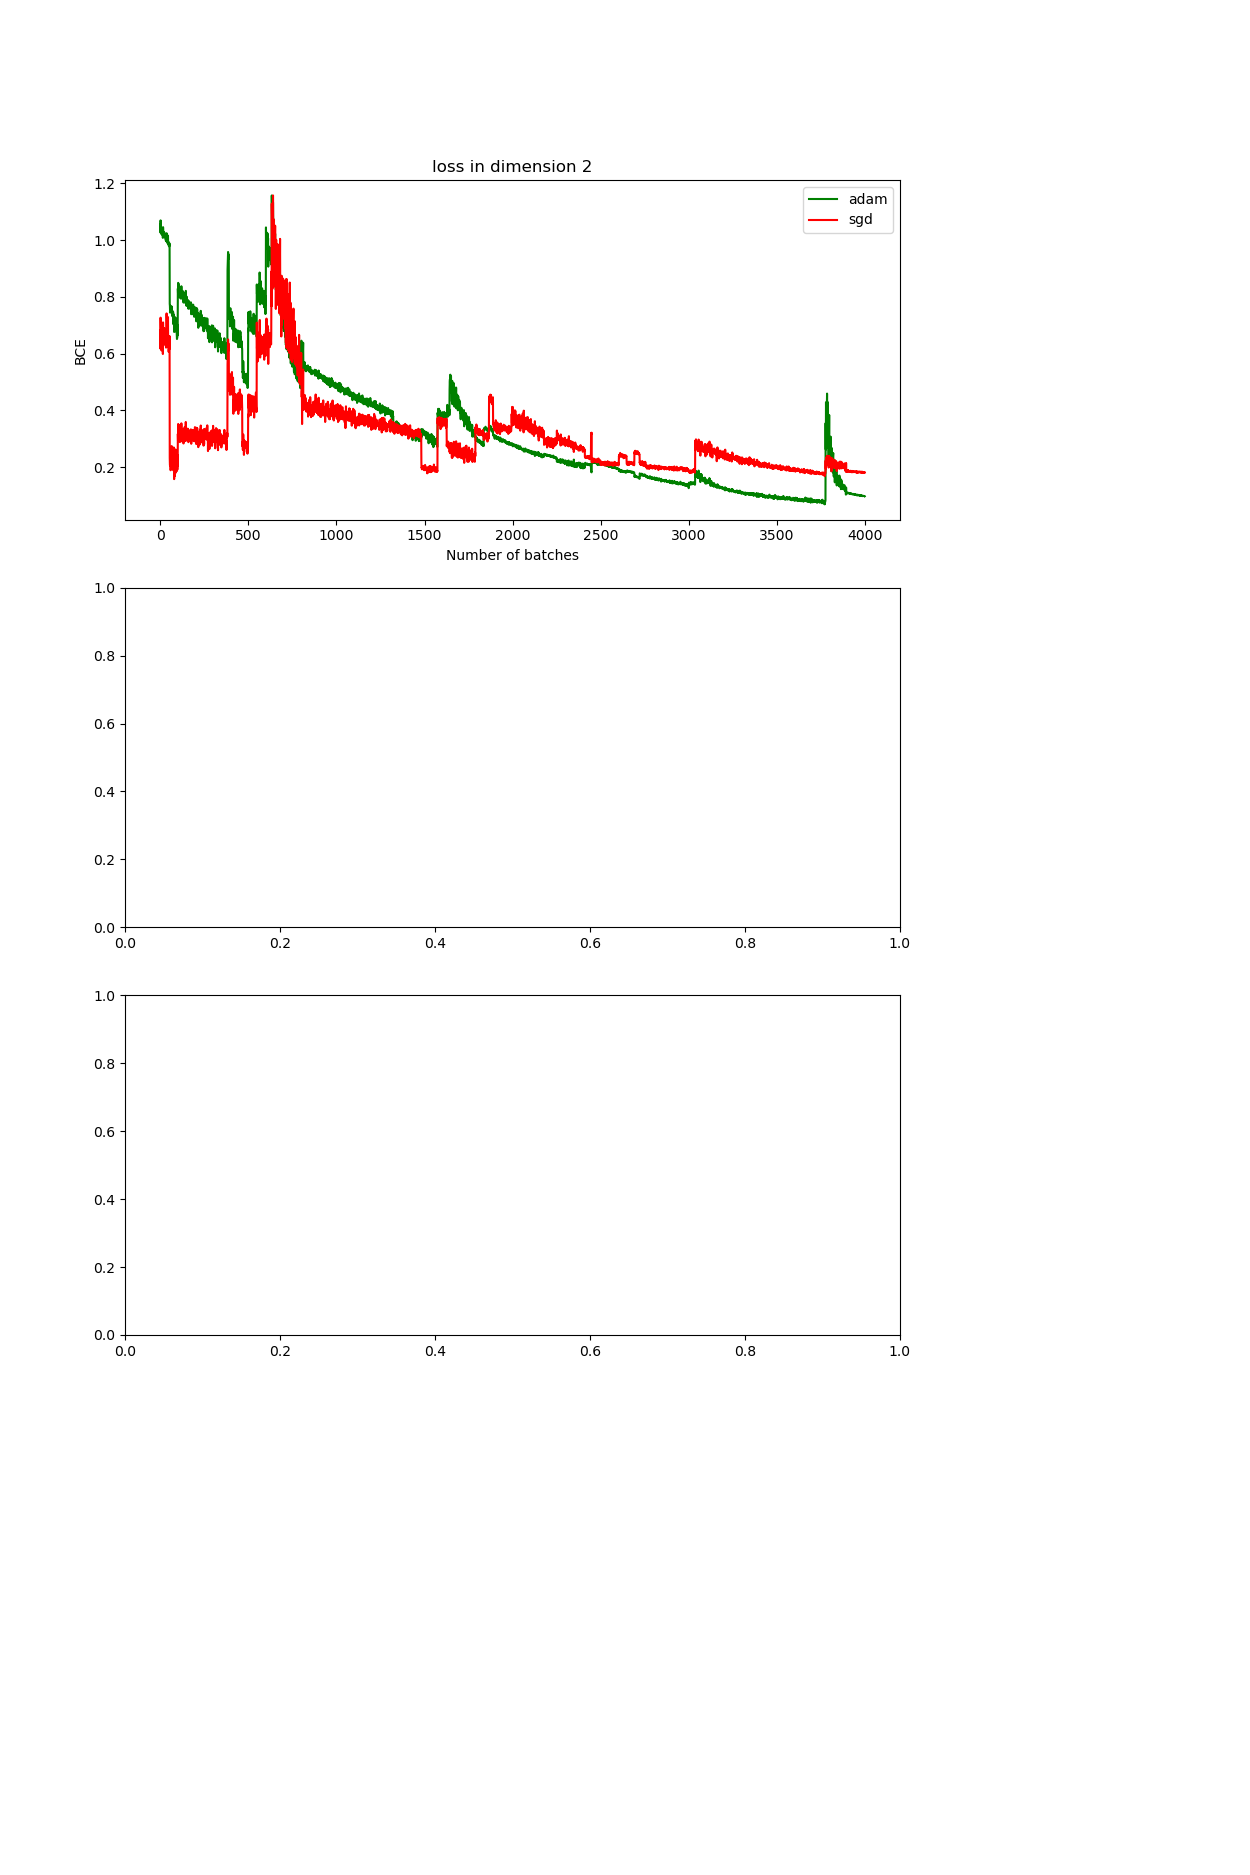

AttributeError: 'AxesSubplot' object has no attribute 'all'

In [17]:
experiment_dim(2)

<IPython.core.display.Javascript object>


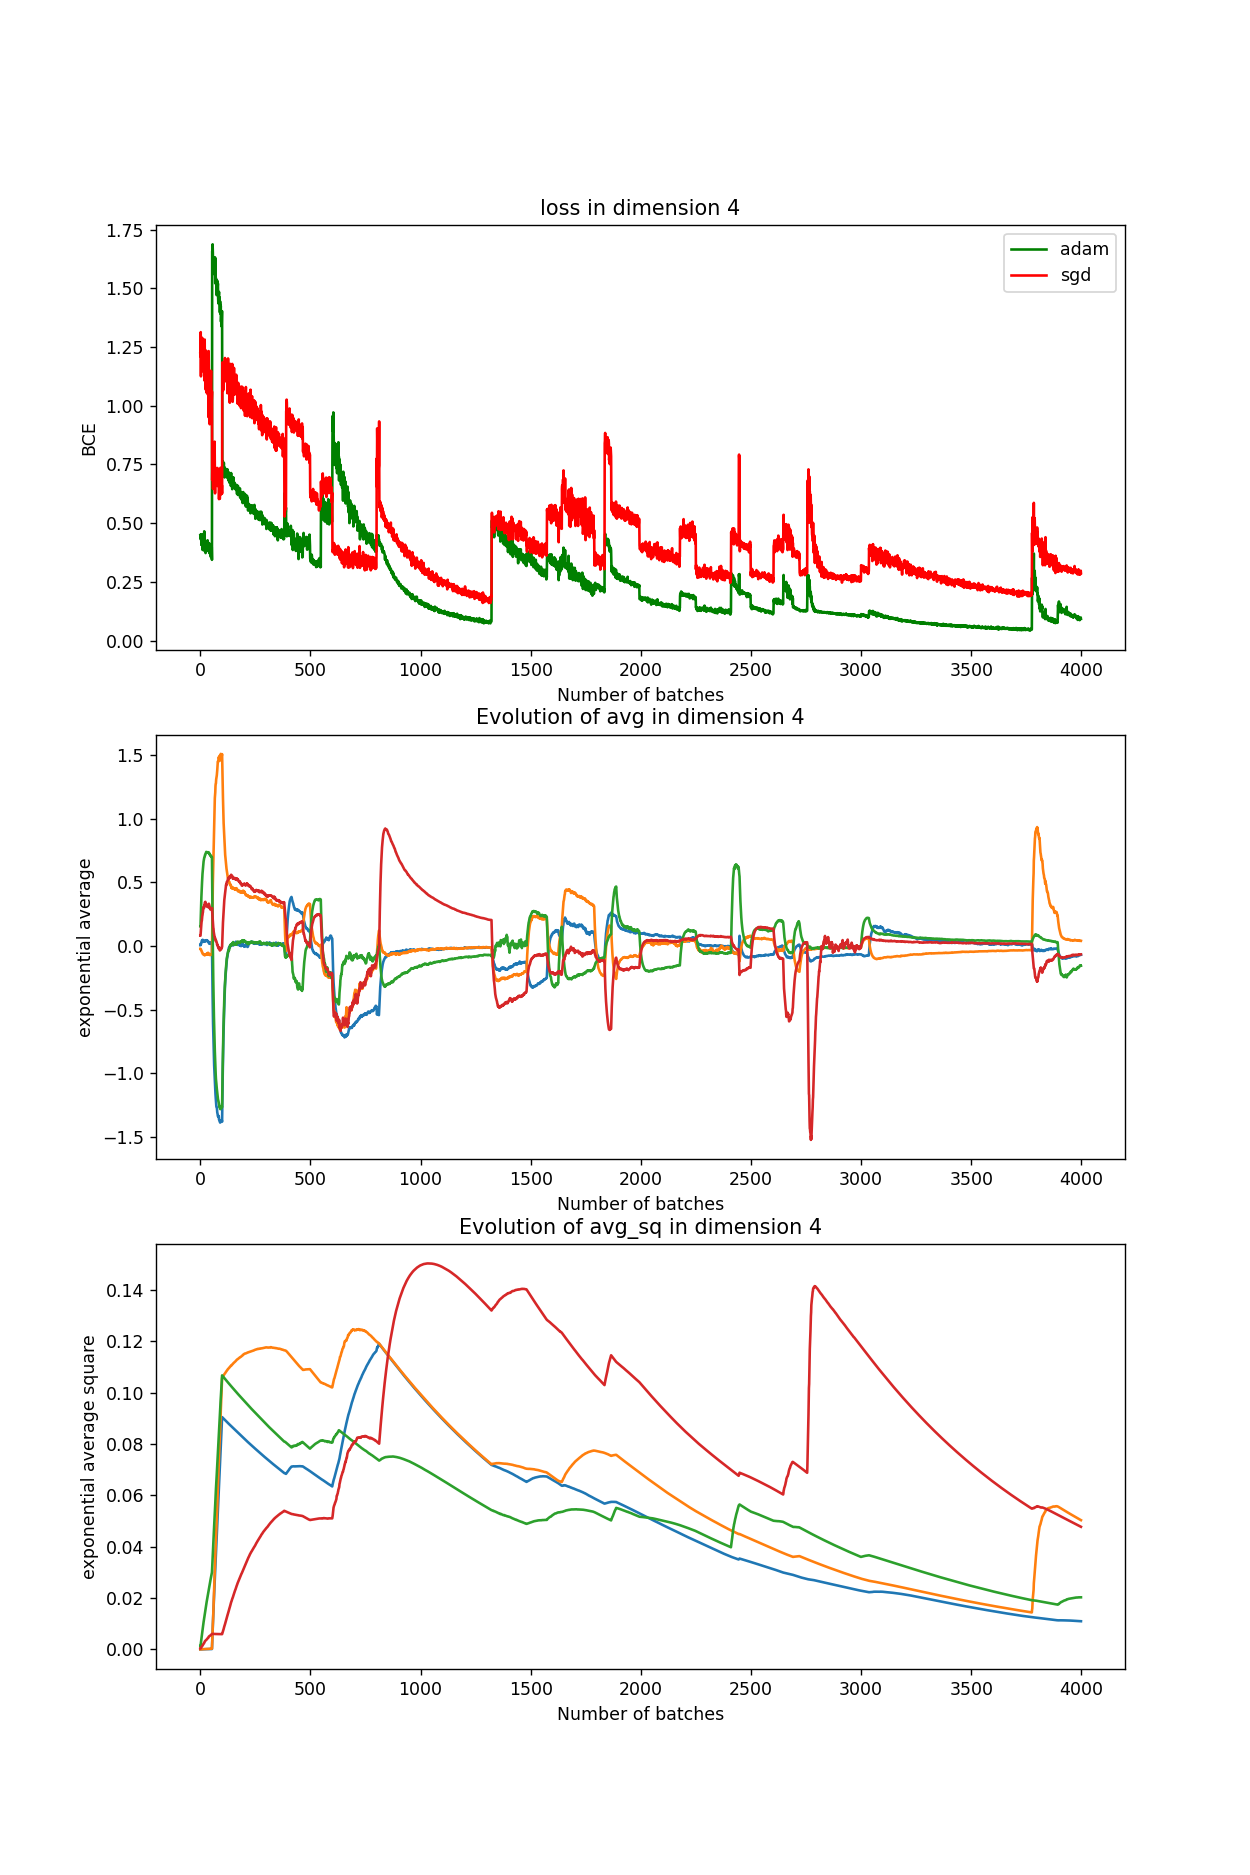

In [25]:
experiment_dim(4)

<IPython.core.display.Javascript object>


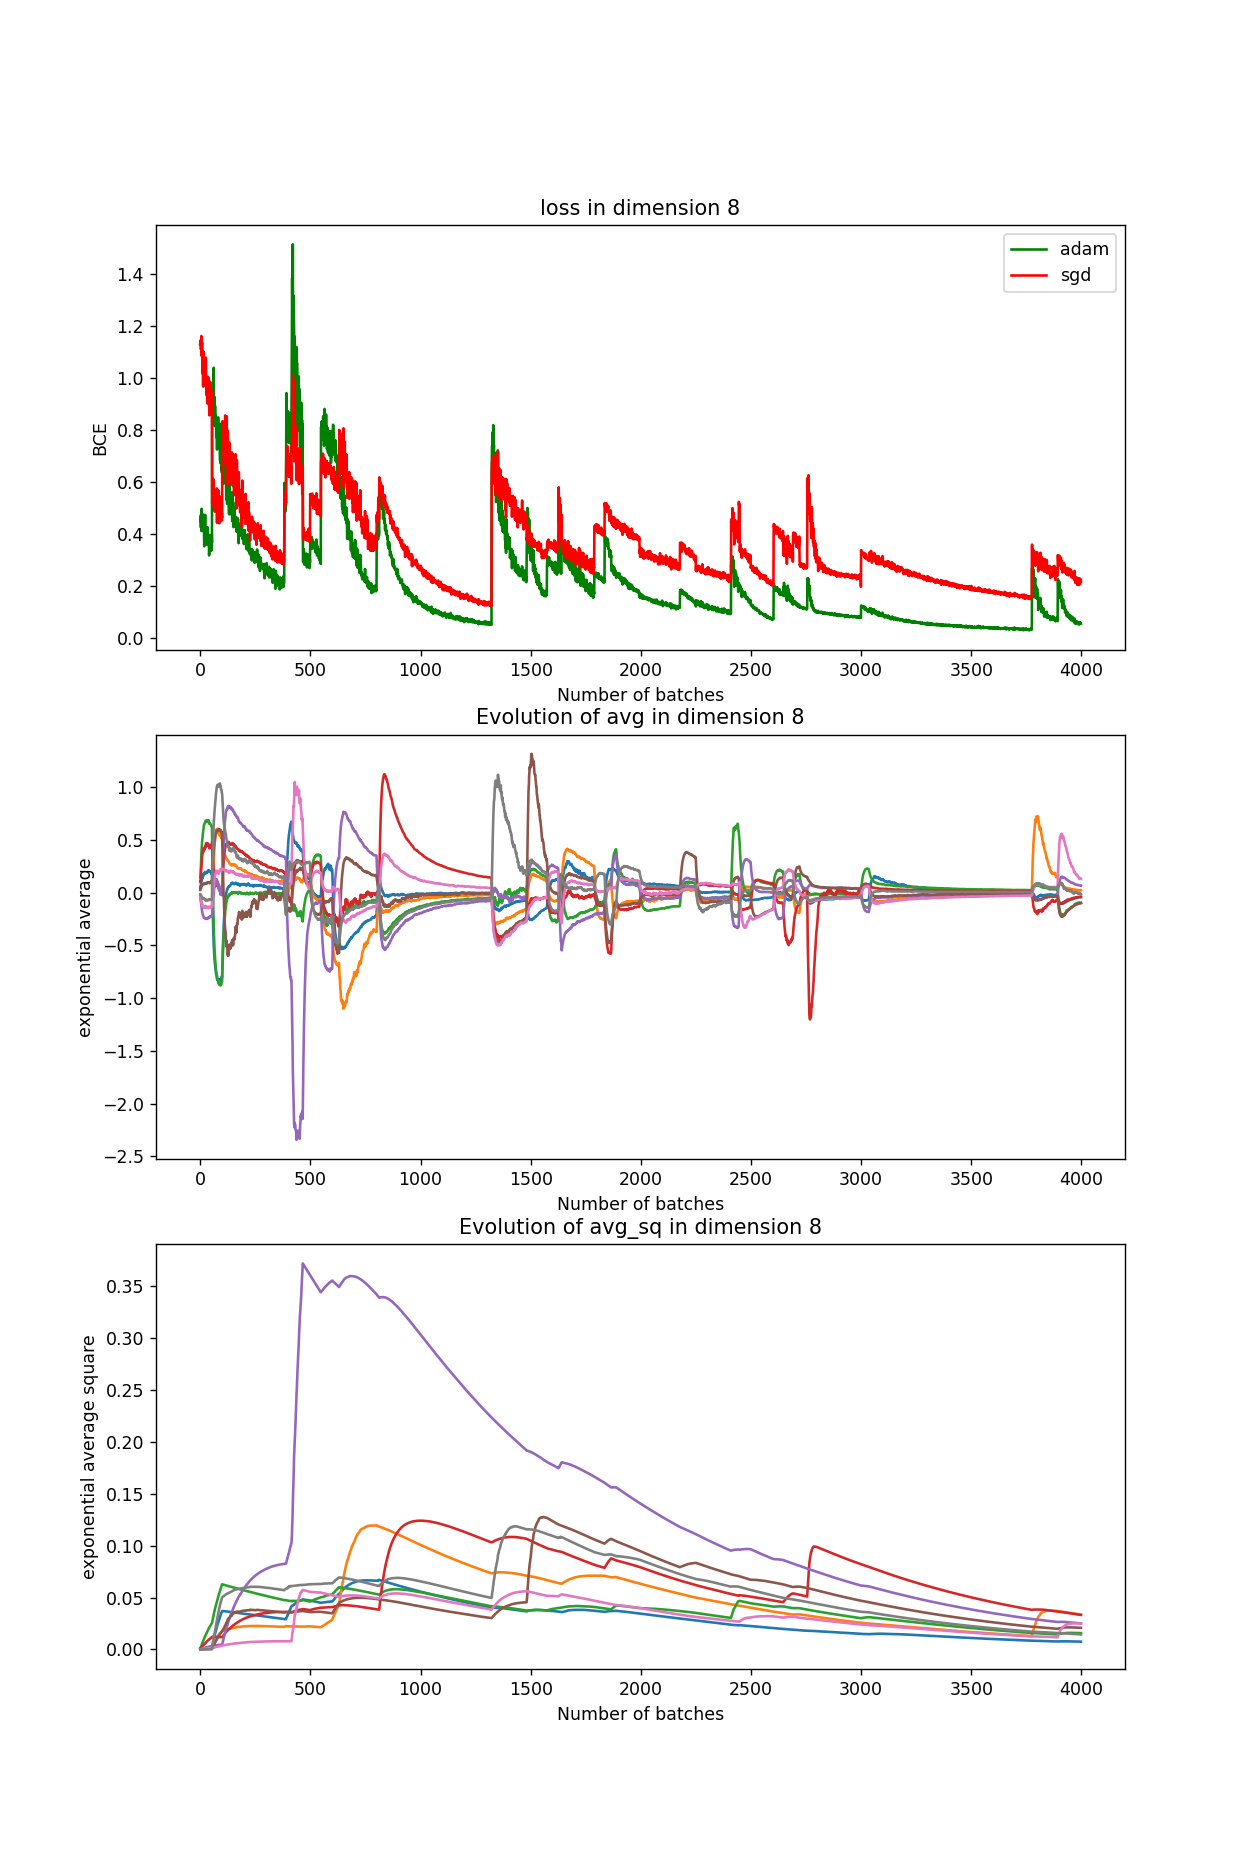

In [26]:
experiment_dim(8)

<IPython.core.display.Javascript object>


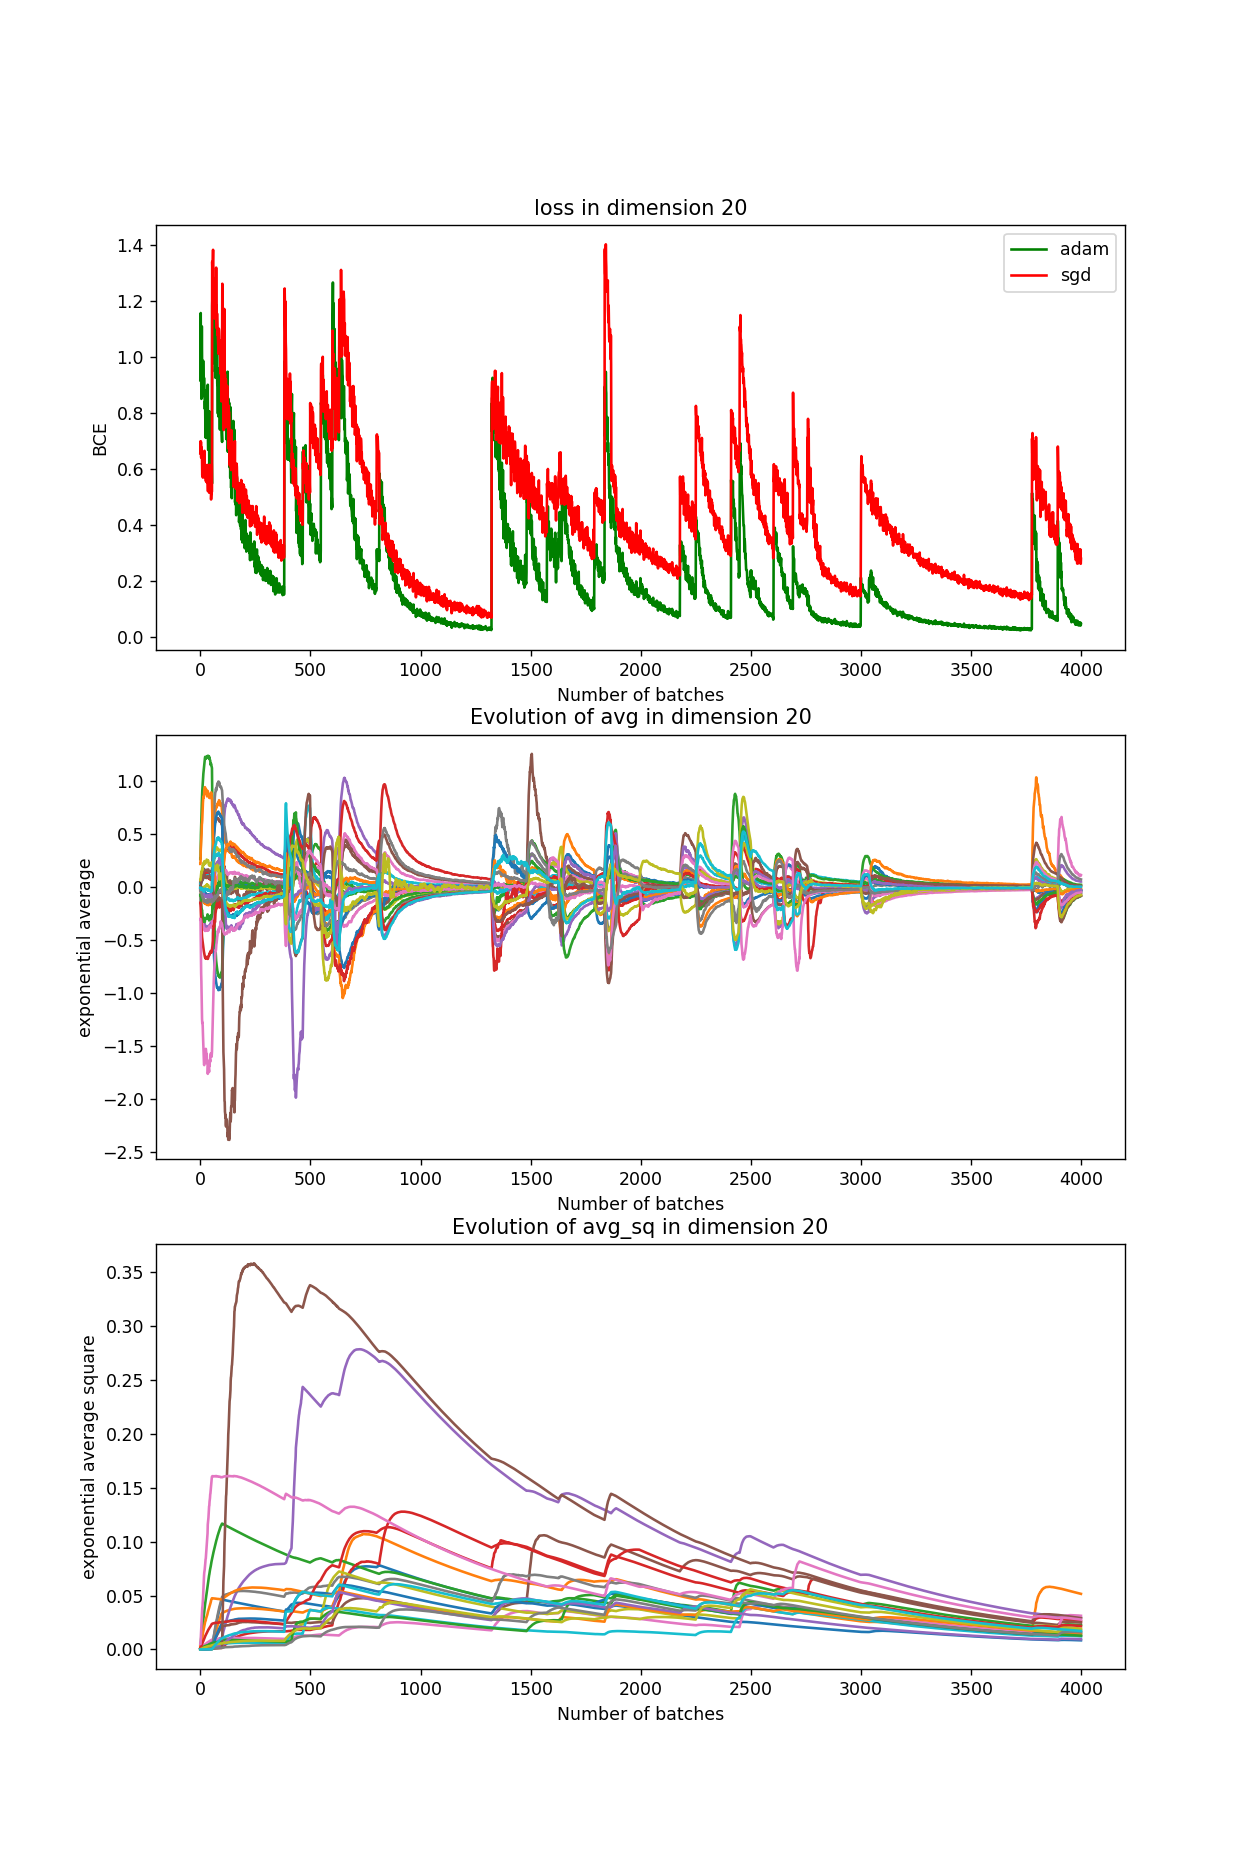

In [27]:
experiment_dim(20)

<IPython.core.display.Javascript object>


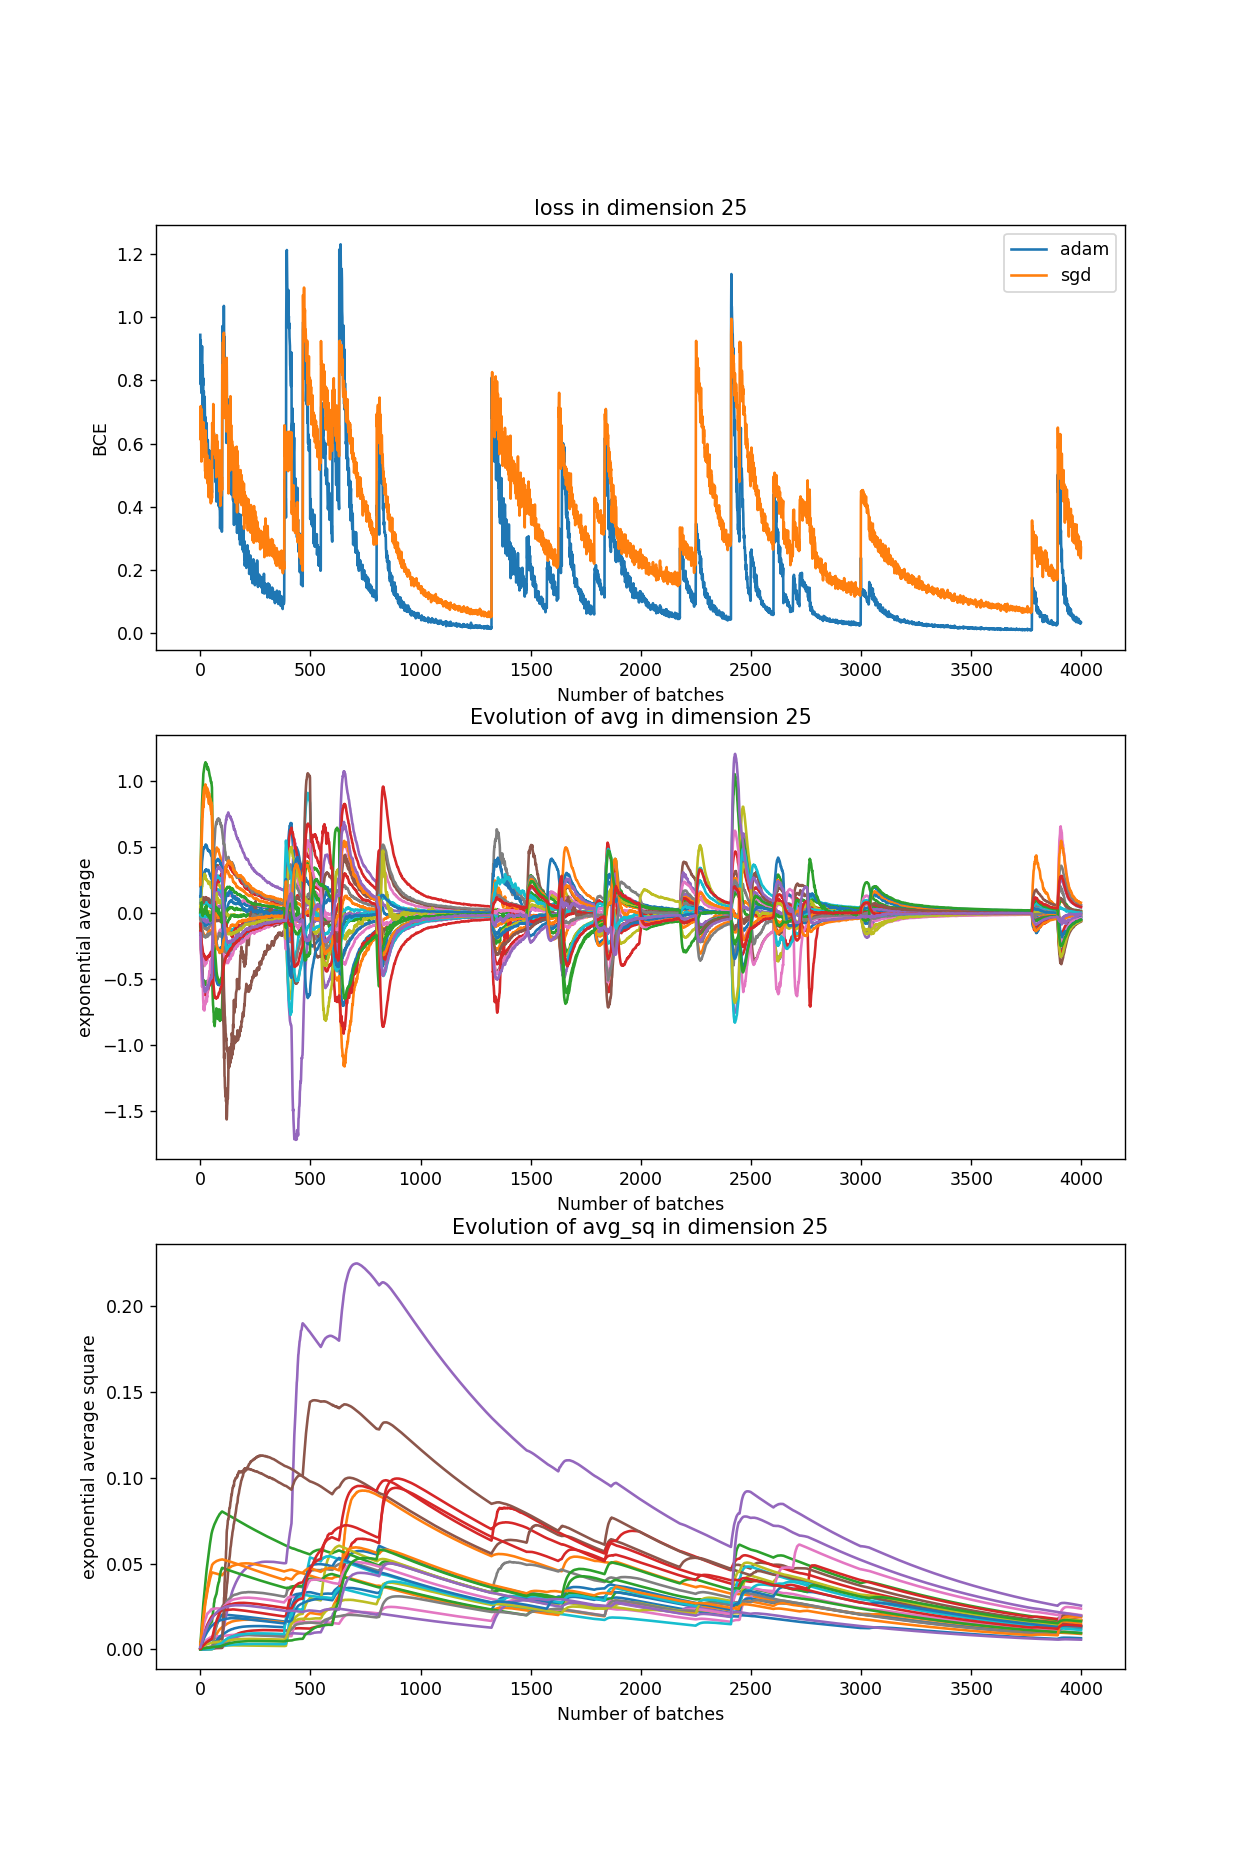

In [17]:
experiment_dim(25)